# **DATA LOADING**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import kagglehub

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve
)

import shap

import dill

In [3]:
path = kagglehub.dataset_download('ealaxi/paysim1')
df = pd.read_csv(Path(path) / 'PS_20174392719_1491204439457_log.csv')

# **EDA**

In [4]:
summ = df.describe(include='all').T
summ['missing'] = df.isna().sum()
summ['unique'] = df.nunique()
summ

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,missing
step,6362620.0,743,NaN,NaN,243.397246,142.331971,1.0,156.0,239.0,335.0,743.0,0
type,6362620,5,CASH_OUT,2237500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
amount,6362620.0,5316900,NaN,NaN,179861.903549,603858.231463,0.0,13389.57,74871.94,208721.4775,92445516.64,0
nameOrig,6362620,6353307,C1530544995,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
oldbalanceOrg,6362620.0,1845844,NaN,NaN,833883.104074,2888242.673007,0.0,0.0,14208.0,107315.175,59585040.37,0
newbalanceOrig,6362620.0,2682586,NaN,NaN,855113.668579,2924048.502971,0.0,0.0,0.0,144258.41,49585040.37,0
nameDest,6362620,2722362,C1286084959,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
oldbalanceDest,6362620.0,3614697,NaN,NaN,1100701.66652,3399180.112969,0.0,0.0,132705.665,943036.7075,356015889.35,0
newbalanceDest,6362620.0,3555499,NaN,NaN,1224996.398202,3674128.942094,0.0,0.0,214661.44,1111909.25,356179278.92,0
isFraud,6362620.0,2,NaN,NaN,0.001291,0.035905,0.0,0.0,0.0,0.0,1.0,0


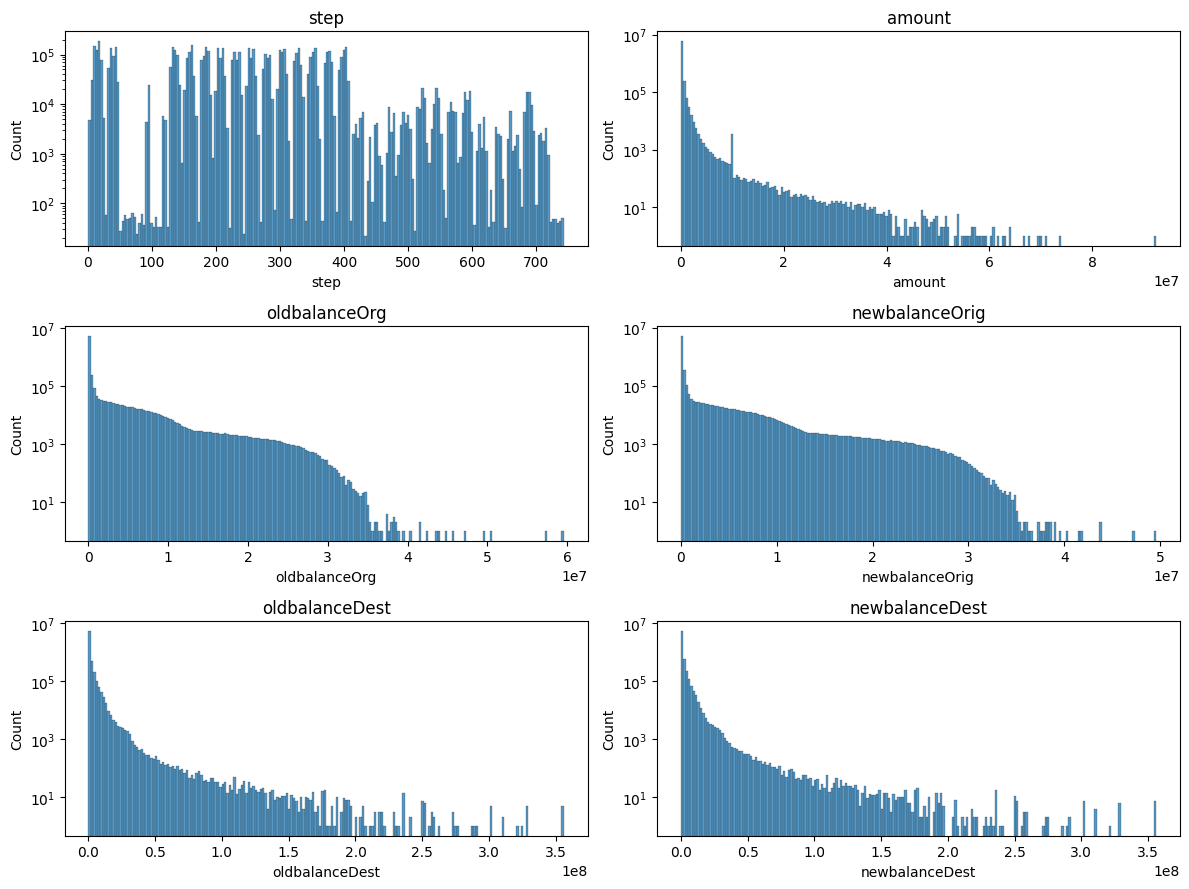

In [5]:
num_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

n_cols = 2
n_rows = (len(num_cols) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=200, ax=axes[i])
    axes[i].set_yscale('log')
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## **Applying log scale on numerical columns**

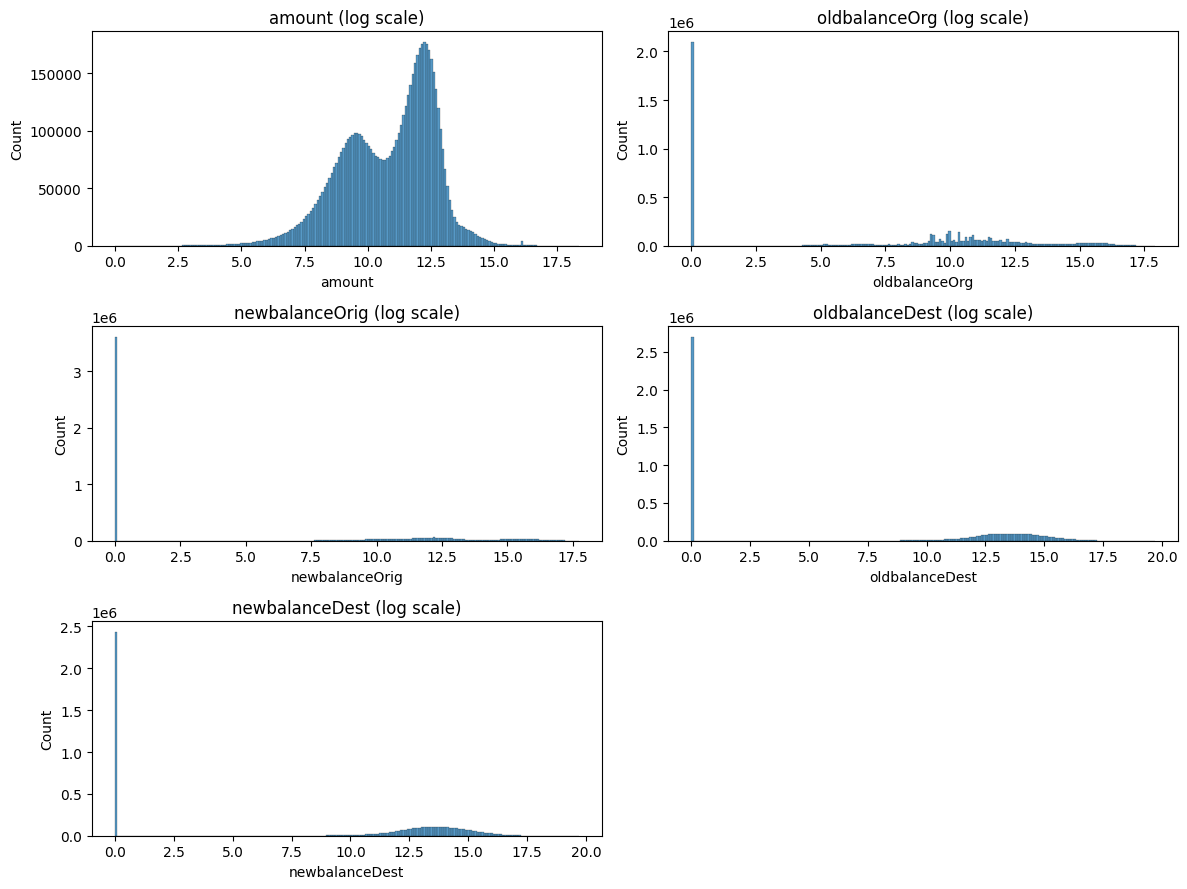

In [6]:
num_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

n_cols = 2
n_rows = (len(num_cols) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    data = df[col]
    data = np.log1p(data)
    sns.histplot(data, bins=200, ax=axes[i])
    axes[i].set_title(f"{col} ({'log scale'})")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

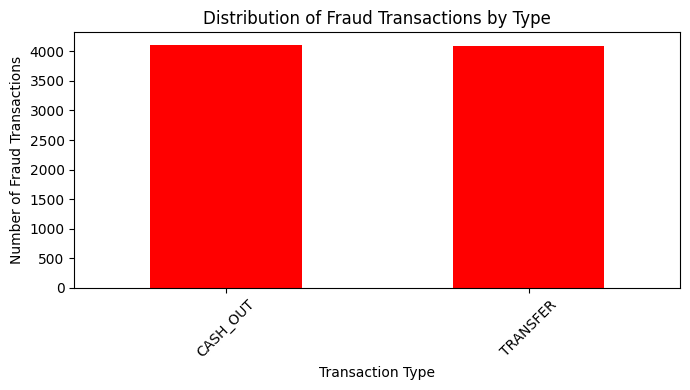

In [7]:
fraud_only = df[df['isFraud'] == 1]
fraud_counts = fraud_only['type'].value_counts()

fraud_counts.plot(kind='bar', figsize=(7,4), color='red')
plt.title('Distribution of Fraud Transactions by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Fraud Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

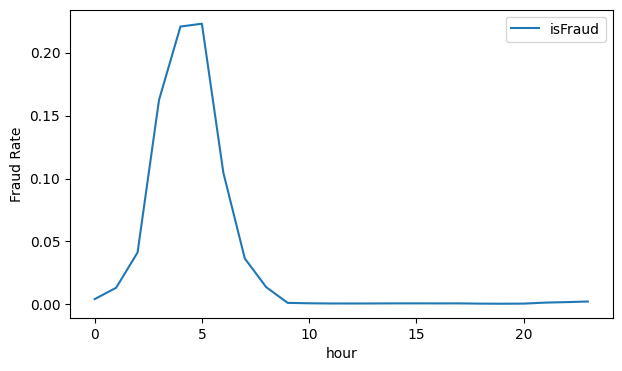

In [8]:
df['hour'] = df['step'] % 24
df.pivot_table(index='hour', values='isFraud').plot(figsize=(7,4))
plt.ylabel('Fraud Rate')
plt.show()

In [9]:
df['hour'] = df['step'] % 24
fraud_rate_by_hour = df.pivot_table(index='hour', values='isFraud')

peak_hour = fraud_rate_by_hour['isFraud'].idxmax()
peak_value = fraud_rate_by_hour['isFraud'].max()

print(f"Peak fraud occurs at hour: {peak_hour} with a rate of {peak_value:.4f}")

Peak fraud occurs at hour: 5 with a rate of 0.2230


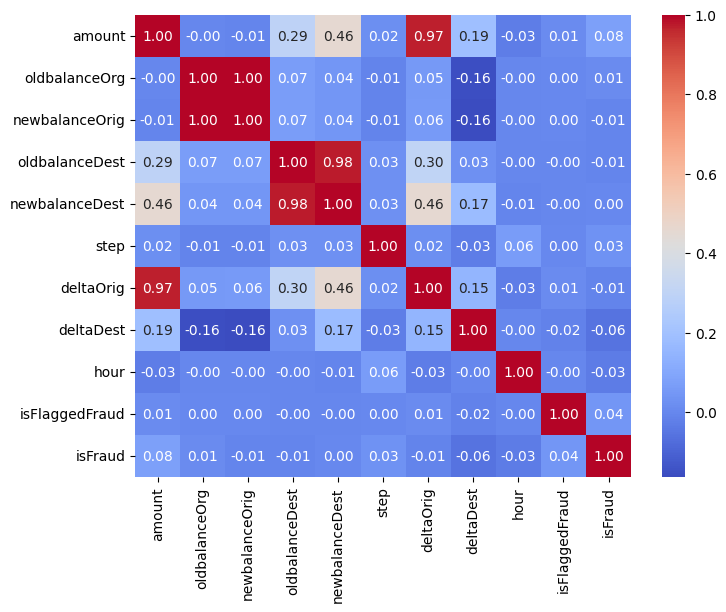

In [12]:
corr = df[num_cols + ['step','deltaOrig','deltaDest','hour','isFlaggedFraud','isFraud']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

In [13]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,deltaOrig,deltaDest
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,1,-1.455192e-11,-9.839640e+03
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,1,1.136868e-12,-1.864280e+03
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,1,0.000000e+00,-1.810000e+02
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,1,0.000000e+00,-2.136300e+04
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,1,0.000000e+00,-1.166814e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,23,0.000000e+00,0.000000e+00
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,23,0.000000e+00,-6.311409e+06
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,23,0.000000e+00,-1.000000e-02
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,23,0.000000e+00,-8.500025e+05


In [14]:
df['isFraud'].value_counts(normalize=True)

,proportion
isFraud,
0,0.998709
1,0.001291


In [15]:
pair_stats = df.groupby(['nameOrig', 'nameDest']).agg(
    total_txns=('isFraud', 'count'),
    fraud_txns=('isFraud', 'sum')
)
pair_stats['fraud_percentage'] = pair_stats['fraud_txns'] / pair_stats['total_txns'] * 100
pair_stats_sorted = pair_stats.sort_values(by='fraud_percentage', ascending=False)
print(pair_stats_sorted.head(10))

                         total_txns  fraud_txns  fraud_percentage
nameOrig    nameDest                                             
C1013220847 C1135493559           1           1             100.0
C1420516343 C567741813            1           1             100.0
C934338438  C209796396            1           1             100.0
C144024686  C241184394            1           1             100.0
C1034673425 C1379589736           1           1             100.0
C1696223343 C1922098798           1           1             100.0
C2103265286 C1983881188           1           1             100.0
C470081604  C365773860            1           1             100.0
C1392276809 C1315942882           1           1             100.0
C2117610925 C1891377178           1           1             100.0


In [16]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'hour', 'deltaOrig', 'deltaDest'],
      dtype='object')

# **Train-Test Split**

In [17]:
X = df.drop(columns=['isFraud','nameOrig', 'nameDest','isFlaggedFraud'])
y = df['isFraud']

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)

# **Feature Engineering**

In [19]:
df['deltaOrig'] = df['newbalanceOrig'] - df['oldbalanceOrg'] + df['amount']
df['deltaDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']
(df[['deltaOrig','deltaDest']] == 0).mean()

,0
deltaOrig,0.069234
deltaDest,0.119504


In [20]:
class NoTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X

no_transform_cols = ['step','amount', 'oldbalanceOrg', 'newbalanceOrig',
                     'oldbalanceDest', 'newbalanceDest', 'deltaOrig', 'deltaDest']
onehot_cols = ['type','hour']

preprocessor = ColumnTransformer(
    transformers=[
        ('no_transform', 'passthrough', no_transform_cols),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False), onehot_cols)
    ],
    remainder='drop'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

In [21]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('no_transform', 'passthrough',
                                                  ['step', 'amount',
                                                   'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest',
                                                   'deltaOrig', 'deltaDest']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['type', 'hour'])]))])

# **LightGBM Classifier Training**

In [22]:
model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)


pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', model)
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [23]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.96      1.00      0.98      2464

    accuracy                           1.00   1908786
   macro avg       0.98      1.00      0.99   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC-AUC Score: 0.9995


# **XGBoost Classifier Training**

In [24]:
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)


pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', model)
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:41:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.96      0.96      0.96      2464

    accuracy                           1.00   1908786
   macro avg       0.98      0.98      0.98   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC-AUC Score: 0.9995


# **Training Stacking Classifier using Logistic Regression as Meta Classifier**

In [25]:
to_float32 = FunctionTransformer(lambda x: x.astype(np.float32))

lgbm_model = Pipeline([
    ('pre', preprocessor),
    ('cast', to_float32),
    ('clf', LGBMClassifier(
        n_estimators=100,
        learning_rate=0.05,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

xgb_model = Pipeline([
    ('pre', preprocessor),
    ('cast', to_float32),
    ('clf', XGBClassifier(
        n_estimators=100,
        learning_rate=0.05,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        use_label_encoder=False,
        eval_metric='logloss',
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',
        grow_policy='lossguide',
        random_state=42,
        n_jobs=-1
    ))
])

print("Training LGBM...")
lgbm_model.fit(X_train, y_train)

print("Training XGBoost...")
xgb_model.fit(X_train, y_train)

print("Generating base model predictions...")
lgbm_proba = lgbm_model.predict_proba(X_test)[:, 1]
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

X_meta = np.vstack([lgbm_proba, xgb_proba]).T

print("Training meta-model (Logistic Regression)...")
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X_meta, y_test)

final_preds = meta_model.predict(X_meta)
final_proba = meta_model.predict_proba(X_meta)[:, 1]

print("Stacked Classification Report:")
print(classification_report(y_test, final_preds))
print(f"Stacked ROC-AUC Score: {roc_auc_score(y_test, final_proba):.4f}")

Training LGBM...
[LightGBM] [Info] Number of positive: 5749, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 4453834, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:43:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Generating base model predictions...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training meta-model (Logistic Regression)...
Stacked Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.99      1.00      0.99      2464

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786

Stacked ROC-AUC Score: 0.9999


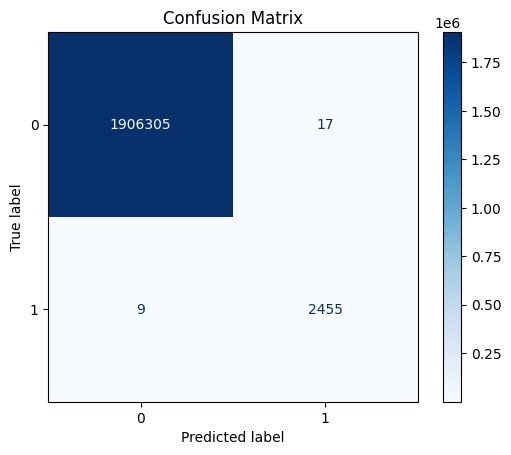

In [26]:
y_pred = pipe.predict(X_test)
cm = confusion_matrix(y_test, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# **Training a Custom rule based model by check prob thershold where false positive is very less from a validation dataset (breaked from training data) and then added rule for type column after some research**

In [27]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

to_float32 = FunctionTransformer(lambda x: x.astype(np.float32))

lgbm = Pipeline([
    ('pre', preprocessor),
    ('cast', to_float32),
    ('clf', LGBMClassifier(n_estimators=100, learning_rate=0.05, class_weight='balanced', random_state=42, n_jobs=-1))
])

xgb = Pipeline([
    ('pre', preprocessor),
    ('cast', to_float32),
    ('clf', XGBClassifier(
        n_estimators=100, learning_rate=0.05,
        scale_pos_weight=(y_tr.value_counts()[0]/y_tr.value_counts()[1]),
        use_label_encoder=False, eval_metric='logloss',
        max_depth=6, subsample=0.8, colsample_bytree=0.8,
        tree_method='hist', grow_policy='lossguide',
        random_state=42, n_jobs=-1
    ))
])

lgbm.fit(X_tr, y_tr)
xgb.fit(X_tr, y_tr)

lgbm_val = lgbm.predict_proba(X_val)[:,1]
xgb_val  = xgb.predict_proba(X_val)[:,1]
meta_X_val = np.vstack([lgbm_val, xgb_val]).T
meta = LogisticRegression(max_iter=1000)
meta.fit(meta_X_val, y_val)
meta_val_proba = meta.predict_proba(meta_X_val)[:,1]

types_val = X_val['type'].values
allowed_val = np.isin(types_val, ['TRANSFER','CASH_OUT'])

def eval_thr(y_true, proba, allowed, thr):
    preds = ((proba >= thr) & allowed).astype(int)
    cm = confusion_matrix(y_true, preds)
    prec = precision_score(y_true, preds, zero_division=0)
    rec = recall_score(y_true, preds, zero_division=0)
    auc = roc_auc_score(y_true, proba)
    return cm, prec, rec, auc

best = None
for t in np.linspace(0.50, 0.999, 100):
    cm, prec, rec, auc = eval_thr(y_val, meta_val_proba, allowed_val, t)
    fp = cm[0,1]; fn = cm[1,0]
    if rec >= 0.995:
        key = (fp, -prec, fn)
        if best is None or key < best[0]:
            best = (key, t, cm, prec, rec, auc)

best_thr = best[1] if best else 0.5

lgbm_test = lgbm.predict_proba(X_test)[:,1]
xgb_test  = xgb.predict_proba(X_test)[:,1]
meta_X_test = np.vstack([lgbm_test, xgb_test]).T
meta_test_proba = meta.predict_proba(meta_X_test)[:,1]

types_test = X_test['type'].values
allowed_test = np.isin(types_test, ['TRANSFER','CASH_OUT'])
preds_test = ((meta_test_proba >= best_thr) & allowed_test).astype(int)

cm = confusion_matrix(y_test, preds_test)
prec = precision_score(y_test, preds_test, zero_division=0)
rec = recall_score(y_test, preds_test, zero_division=0)
auc = roc_auc_score(y_test, meta_test_proba)

print("Chosen threshold (from validation):", best_thr)
print("Confusion matrix:\n", cm)
print("precision:", round(prec,6), "recall:", round(rec,6), "roc_auc:", round(auc,6))
print(classification_report(y_test, preds_test))

[LightGBM] [Info] Number of positive: 4599, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.216411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 3563067, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:45:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Chosen threshold (from validation): 0.8528282828282828
Confusion matrix:
 [[1906321       1]
 [      9    2455]]
precision: 0.999593 recall: 0.996347 roc_auc: 0.999773
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       1.00      1.00      1.00      2464

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786



# **Converting it to Final Custom Model**

In [28]:
class InsightAIMLModel(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        preprocessor,
        val_size=0.2,
        allowed_types=("TRANSFER","CASH_OUT"),
        recall_min=0.995,
        thr_start=0.50,
        thr_end=0.999,
        thr_points=100,
        cast_float32=True,
        random_state=42,
        lgbm_params=None,
        xgb_params=None,
        meta_params=None,
        reason_labels=None
    ):
        self.preprocessor = preprocessor
        self.val_size = val_size
        self.allowed_types = tuple(allowed_types)
        self.recall_min = recall_min
        self.thr_start = thr_start
        self.thr_end = thr_end
        self.thr_points = thr_points
        self.cast_float32 = cast_float32
        self.random_state = random_state
        self.lgbm_params = lgbm_params or dict(
            n_estimators=100, learning_rate=0.05, class_weight="balanced",
            random_state=random_state, n_jobs=-1
        )
        self.xgb_params = xgb_params or dict(
            n_estimators=100, learning_rate=0.05, use_label_encoder=False,
            eval_metric="logloss", max_depth=6, subsample=0.8, colsample_bytree=0.8,
            tree_method="hist", grow_policy="lossguide",
            random_state=random_state, n_jobs=-1
        )
        self.meta_params = meta_params or dict(max_iter=1000)
        self.reason_labels = reason_labels or {}

    def _make_pipes(self, y_tr):
        to_float32 = FunctionTransformer(lambda x: x.astype(np.float32)) if self.cast_float32 else FunctionTransformer(lambda x: x)
        if "scale_pos_weight" not in self.xgb_params:
            pos_weight = (y_tr.value_counts()[0] / y_tr.value_counts()[1])
            self.xgb_params = {**self.xgb_params, "scale_pos_weight": float(pos_weight)}
        self.lgbm_pipe_ = Pipeline([
            ("pre", self.preprocessor),
            ("cast", to_float32),
            ("clf", LGBMClassifier(**self.lgbm_params)),
        ])
        self.xgb_pipe_  = Pipeline([
            ("pre", self.preprocessor),
            ("cast", to_float32),
            ("clf", XGBClassifier(**self.xgb_params)),
        ])

    def _pick_threshold(self, y_true, proba, allowed_mask):
        best = None
        for t in np.linspace(self.thr_start, self.thr_end, self.thr_points):
            preds = ((proba >= t) & allowed_mask).astype(int)
            cm = confusion_matrix(y_true, preds, labels=[0,1])
            fp, fn = cm[0,1], cm[1,0]
            prec = precision_score(y_true, preds, zero_division=0)
            rec  = recall_score(y_true, preds, zero_division=0)
            if rec >= self.recall_min:
                key = (fp, -prec, fn)
                if best is None or key < best[0]:
                    best = (key, t)
        return 0.5 if best is None else best[1]

    @staticmethod
    def _to_numpy(Xt):
        if hasattr(Xt, "toarray"):
            return Xt.toarray()
        return np.asarray(Xt)

    @staticmethod
    def _get_feature_names(pre):
        try:
            return pre.get_feature_names_out()
        except Exception:
            return None

    @staticmethod
    def _extract_pos_shap(shap_values):
        if isinstance(shap_values, (list, tuple)) and len(shap_values) > 1:
            return shap_values[1]
        return shap_values

    def _tree_shap_single(self, pipe, Xt_np, feature_names):
        try:
            import shap
            clf = pipe.named_steps["clf"]
            explainer = shap.TreeExplainer(clf)
            sv = explainer.shap_values(Xt_np)
            sv_pos = self._extract_pos_shap(sv).reshape(-1)
            expected = explainer.expected_value
            if isinstance(expected, (list, tuple, np.ndarray)):
                expected = expected[-1]
            if feature_names is None:
                feature_names = [f"f{i}" for i in range(Xt_np.shape[1])]
            df = pd.DataFrame({"feature": feature_names, "shap": sv_pos})
            df["abs_shap"] = df["shap"].abs()
            df = df.sort_values("abs_shap", ascending=False)
            return df, float(expected), True, None
        except Exception as e:
            return pd.DataFrame(), None, False, str(e)

    @staticmethod
    def _logit_to_prob(z):
        return 1.0 / (1.0 + np.exp(-z))

    def _label(self, feat):
        return self.reason_labels.get(feat, feat)

    def fit(self, X, y):
        X_tr, X_val, y_tr, y_val = train_test_split(
            X, y, test_size=self.val_size, stratify=y, random_state=self.random_state
        )
        self.classes_ = np.unique(y)
        self._make_pipes(y_tr)
        self.lgbm_pipe_.fit(X_tr, y_tr)
        self.xgb_pipe_.fit(X_tr, y_tr)
        lgbm_val = self.lgbm_pipe_.predict_proba(X_val)[:,1]
        xgb_val  = self.xgb_pipe_.predict_proba(X_val)[:,1]
        meta_X_val = np.vstack([lgbm_val, xgb_val]).T
        self.meta_model_ = LogisticRegression(**self.meta_params)
        self.meta_model_.fit(meta_X_val, y_val)
        types_val = X_val["type"].values if "type" in X_val.columns else np.array([None]*len(X_val))
        allowed_val = np.isin(types_val, self.allowed_types)
        meta_val_proba = self.meta_model_.predict_proba(meta_X_val)[:,1]
        self.threshold_ = self._pick_threshold(y_val, meta_val_proba, allowed_val)
        return self

    def predict_proba(self, X):
        lgbm_p = self.lgbm_pipe_.predict_proba(X)[:,1]
        xgb_p  = self.xgb_pipe_.predict_proba(X)[:,1]
        meta_X = np.vstack([lgbm_p, xgb_p]).T
        p1 = self.meta_model_.predict_proba(meta_X)[:,1]
        return np.column_stack([1 - p1, p1])

    def predict(self, X):
        proba = self.predict_proba(X)[:,1]
        types_arr = X["type"].values if "type" in X.columns else np.array([None]*len(X))
        allowed = np.isin(types_arr, self.allowed_types)
        return ((proba >= self.threshold_) & allowed).astype(int)

    def decision_function(self, X):
        return self.predict_proba(X)[:,1]

    def set_threshold(self, X_val, y_val):
        p = self.predict_proba(X_val)[:,1]
        types_arr = X_val["type"].values if "type" in X_val.columns else np.array([None]*len(X_val))
        allowed = np.isin(types_arr, self.allowed_types)
        self.threshold_ = self._pick_threshold(y_val, p, allowed)
        return self.threshold_

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

    def evaluate(self, X, y):
        p = self.predict_proba(X)[:,1]
        preds = self.predict(X)
        cm = confusion_matrix(y, preds, labels=[0,1])
        prec = precision_score(y, preds, zero_division=0)
        rec  = recall_score(y, preds, zero_division=0)
        auc  = roc_auc_score(y, p)
        return {
            "confusion_matrix": cm,
            "precision": prec,
            "recall": rec,
            "roc_auc": auc,
            "threshold": getattr(self, "threshold_", None)
        }

    def explain(self, X_row: pd.DataFrame, top_k: int = 12, plot: bool = False):
        if not isinstance(X_row, pd.DataFrame):
            raise ValueError("X_row must be a pandas DataFrame.")
        X_row = X_row.iloc[:1].copy()
        if "type" in X_row.columns:
            type_val = X_row["type"].iloc[0]
            allowed = bool(type_val in self.allowed_types)
        else:
            type_val = None
            allowed = False
        p_lgbm = float(self.lgbm_pipe_.predict_proba(X_row)[:,1][0])
        p_xgb  = float(self.xgb_pipe_.predict_proba(X_row)[:,1][0])
        coef = self.meta_model_.coef_.ravel()
        intercept = float(self.meta_model_.intercept_.ravel()[0])
        z = intercept + coef[0]*p_lgbm + coef[1]*p_xgb
        p_meta = float(self._logit_to_prob(z))
        final_pred = int(allowed and (p_meta >= self.threshold_))
        pre = self.lgbm_pipe_.named_steps["pre"]
        Xt = pre.transform(X_row)
        if self.cast_float32 and hasattr(Xt, "astype"):
            try:
                Xt = Xt.astype(np.float32)
            except Exception:
                pass
        Xt_np = self._to_numpy(Xt)
        feat_names = self._get_feature_names(pre)
        lgbm_df, lgbm_base, lgbm_ok, lgbm_err = self._tree_shap_single(self.lgbm_pipe_, Xt_np, feat_names)
        xgb_df,  xgb_base,  xgb_ok,  xgb_err  = self._tree_shap_single(self.xgb_pipe_,  Xt_np, feat_names)
        if plot and lgbm_ok and not lgbm_df.empty:
            import matplotlib.pyplot as plt
            top = lgbm_df.head(top_k).iloc[::-1]
            plt.figure(figsize=(6, max(2, 0.35*len(top))))
            plt.barh(top["feature"], top["shap"])
            plt.title("LGBM SHAP contributions (sample)")
            plt.tight_layout()
            plt.show()
        if plot and xgb_ok and not xgb_df.empty:
            import matplotlib.pyplot as plt
            top = xgb_df.head(top_k).iloc[::-1]
            plt.figure(figsize=(6, max(2, 0.35*len(top))))
            plt.barh(top["feature"], top["shap"])
            plt.title("XGB SHAP contributions (sample)")
            plt.tight_layout()
            plt.show()
        return {
            "type_value": type_val,
            "allowed_type": allowed,
            "p_lgbm": p_lgbm,
            "p_xgb": p_xgb,
            "meta_intercept": intercept,
            "meta_coef_lgbm": float(coef[0]),
            "meta_coef_xgb": float(coef[1]),
            "meta_logit": float(z),
            "meta_proba": p_meta,
            "threshold": float(getattr(self, "threshold_", 0.5)),
            "final_pred": final_pred,
            "lgbm_shap_available": lgbm_ok,
            "xgb_shap_available": xgb_ok,
            "lgbm_shap_error": lgbm_err,
            "xgb_shap_error": xgb_err,
            "lgbm_top_features": lgbm_df.head(top_k).reset_index(drop=True),
            "xgb_top_features": xgb_df.head(top_k).reset_index(drop=True),
        }

    def explain_text(self, X_row: pd.DataFrame, top_k: int = 5):
        if not isinstance(X_row, pd.DataFrame):
            raise ValueError("X_row must be a pandas DataFrame.")
        X_row = X_row.iloc[:1].copy()
        exp = self.explain(X_row, top_k=max(top_k, 10), plot=False)
        p_lgbm = exp["p_lgbm"]; p_xgb = exp["p_xgb"]; p_meta = exp["meta_proba"]
        thr = exp["threshold"]; allowed = exp["allowed_type"]; tval = exp["type_value"]
        final_pred = exp["final_pred"]; w_l = exp["meta_coef_lgbm"]; w_x = exp["meta_coef_xgb"]
        reasons = []
        counter_reasons = []
        if exp["lgbm_shap_available"] and exp["xgb_shap_available"]:
            ldf = exp["lgbm_top_features"][["feature","shap"]].copy()
            xdf = exp["xgb_top_features"][["feature","shap"]].copy()
            ldf = ldf.groupby("feature", as_index=False)["shap"].sum()
            xdf = xdf.groupby("feature", as_index=False)["shap"].sum()
            merged = ldf.merge(xdf, on="feature", how="outer", suffixes=("_lgbm","_xgb")).fillna(0.0)
            aw_l, aw_x = abs(w_l), abs(w_x)
            denom = aw_l + aw_x if (aw_l + aw_x) > 0 else 1.0
            wl, wx = aw_l/denom, aw_x/denom
            merged["combined_shap"] = wl*merged["shap_lgbm"] + wx*merged["shap_xgb"]
            merged["abs_combined"] = merged["combined_shap"].abs()
            merged = merged.sort_values("abs_combined", ascending=False)
            pos_df = merged[merged["combined_shap"] > 0].head(top_k)
            for _, r in pos_df.iterrows():
                reasons.append({
                    "feature": self._label(r["feature"]),
                    "raw_feature": r["feature"],
                    "impact": float(r["combined_shap"]),
                    "direction": "increases_fraud_risk"
                })
            neg_df = merged[merged["combined_shap"] < 0].head(top_k)
            for _, r in neg_df.iterrows():
                counter_reasons.append({
                    "feature": self._label(r["feature"]),
                    "raw_feature": r["feature"],
                    "impact": float(r["combined_shap"]),
                    "direction": "reduces_fraud_risk"
                })
        else:
            reasons = [{
                "feature": "Model signals",
                "raw_feature": "probabilities",
                "impact": float(max(p_lgbm, p_xgb) - thr),
                "direction": "increases_fraud_risk" if (p_meta >= thr and allowed) else "reduces_fraud_risk"
            }]
        if not allowed:
            rule_text = f"Transaction type={tval!r} is outside monitored types {list(self.allowed_types)}; treated as NOT FRAUD."
        else:
            rule_text = f"Transaction type={tval!r} is within monitored types {list(self.allowed_types)}."
        decision_text = "Flagged as FRAUD." if final_pred == 1 else "Predicted as NOT FRAUD."
        details_text = (
            f"{rule_text} Combined probability={p_meta:.6f} vs threshold={thr:.6f} "
            f"(LightGBM={p_lgbm:.6f}, XGBoost={p_xgb:.6f})."
        )
        return {
            "decision": int(final_pred),
            "decision_text": decision_text,
            "details_text": details_text,
            "probabilities": {
                "p_meta": float(p_meta),
                "p_lgbm": float(p_lgbm),
                "p_xgb": float(p_xgb),
                "threshold": float(thr)
            },
            "business_rule": {
                "allowed": bool(allowed),
                "type_value": tval,
                "allowed_types": list(self.allowed_types)
            },
            "reasons": reasons,
            "counter_reasons": counter_reasons
        }

In [29]:
model = InsightAIMLModel(preprocessor=preprocessor, val_size=0.2, recall_min=0.995)
model.fit(X_train, y_train)
metrics = model.evaluate(X_test, y_test)
print(metrics["confusion_matrix"], metrics["precision"], metrics["recall"], metrics["roc_auc"], metrics["threshold"])
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

[LightGBM] [Info] Number of positive: 4599, number of negative: 3558468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2094
[LightGBM] [Info] Number of data points in the train set: 3563067, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:48:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[[1906321       1]
 [      9    2455]] 0.9995928338762216 0.9963474025974026 0.9997726042882304 0.8528282828282828


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# **Explainability of the Model**

In [30]:
row = X_test.iloc[[130]]
out = model.explain_text(row, top_k=5)

print(out["decision_text"])
print(out["details_text"])
for r in out["reasons"]:
    print("•", r["feature"], "→", r["direction"], f"(impact={r['impact']:.4f})")
for r in out["counter_reasons"]:
    print("•", r["feature"], "→", r["direction"], f"(impact={r['impact']:.4f})")

Predicted as NOT FRAUD.
Transaction type='CASH_OUT' is within monitored types ['TRANSFER', 'CASH_OUT']. Combined probability=0.000112 vs threshold=0.852828 (LightGBM=0.003448, XGBoost=0.008875).
• no_transform__newbalanceOrig → increases_fraud_risk (impact=0.5866)
• no_transform__oldbalanceDest → increases_fraud_risk (impact=0.1275)
• onehot__type_PAYMENT → increases_fraud_risk (impact=0.0472)
• onehot__type_CASH_OUT → increases_fraud_risk (impact=0.0419)
• no_transform__deltaOrig → reduces_fraud_risk (impact=-2.5349)
• no_transform__oldbalanceOrg → reduces_fraud_risk (impact=-0.3751)
• no_transform__step → reduces_fraud_risk (impact=-0.0845)
• no_transform__newbalanceDest → reduces_fraud_risk (impact=-0.0534)
• no_transform__amount → reduces_fraud_risk (impact=-0.0497)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


#  **Final Model Evaulation**

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       1.00      1.00      1.00      2464

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786



Confusion matrix:
 [[1906321       1]
 [      9    2455]]
TP=2455 FP=1 TN=1906321 FN=9
Precision=0.999593 Recall=0.996347 AUC=0.999773

Classification report:
               precision    recall  f1-score   support

           0   0.999995  0.999999  0.999997   1906322
           1   0.999593  0.996347  0.997967      2464

    accuracy                       0.999995   1908786
   macro avg   0.999794  0.998173  0.998982   1908786
weighted avg   0.999995  0.999995  0.999995   1908786



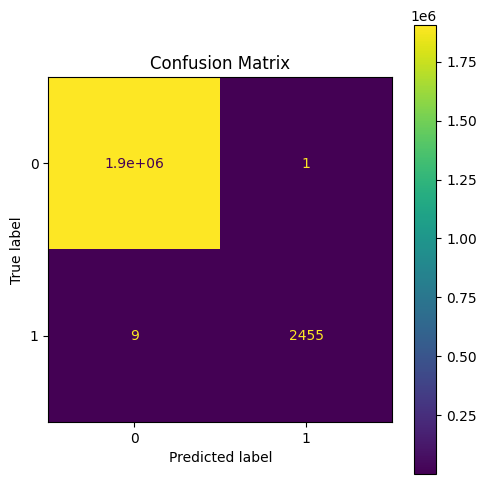

In [32]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()

auc = roc_auc_score(y_test, y_proba)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)

print("Confusion matrix:\n", cm)
print(f"TP={tp} FP={fp} TN={tn} FN={fn}")
print(f"Precision={prec:.6f} Recall={rec:.6f} AUC={auc:.6f}")
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=6))

fig = plt.figure(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(ax=plt.gca())
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

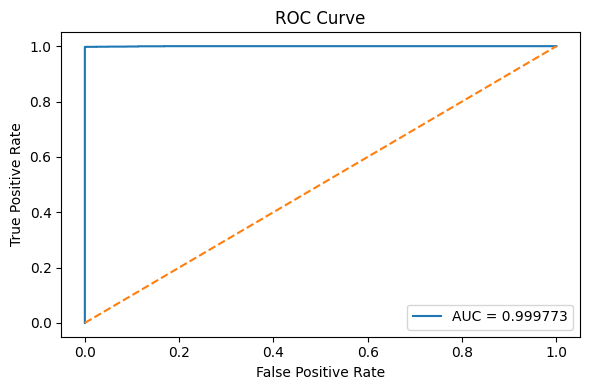

In [33]:
fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.6f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# **Download Final Model**

In [34]:
insight_model = model
model_path = "insightai_fraud_model.pkl"

with open(model_path, 'wb') as f:
    dill.dump(insight_model, f)

print(f"Model saved successfully to {model_path}")

def load_model_with_dill(model_path):
    with open(model_path, 'rb') as f:
        loaded_model = dill.load(f)
    return loaded_model

Model saved successfully to insightai_fraud_model.pkl
